Mention the appropriate informations in the first cell below and run everything.

In [1]:
#Dataset (downloadable from "https://storage.googleapis.com/dft-statistics/road-traffic/downloads/data-gov-uk/dft_traffic_counts_aadf.zip").
#Sample points are the points which is collected manually by hand(in csv format) consist of 'Distance','Cars', and 'Year' columns, which represents number of cars are seen at a distance in that year.

path_to_dataset='D:/traffic_data_analysis/dft_traffic_counts_aadf/dft_traffic_counts_aadf.csv'
path_to_sample_points='D:/traffic_data_analysis/sample_measurements/West_1.csv'

#Mention the starting point from where you are taking the manual measurements. You can find the information inside the 'sample_measurements' folder
s_ln=-3.5958771
s_lat=52.1577699

#Mention the strip's size (in km) for which you want to do the comparison.
strip_height=10
strip_length=145

#Mention the traffic lower bound. Usually set this to 1000.
traffic_bound=1000

#Mention the path to save the figures.
path_to_save='D:/'

In [2]:
#This cell contains all packages and the functions that we are going to use
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from math import radians, cos, sin, asin, sqrt, asin, atan2, degrees 
import seaborn as sns

#Below describes distance between two points function
def distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)



#Below is the function which returns the coordinates of a point which is a given distance apart from a given staring point.
def get_point_at_distance(lat1, lon1, d, bearing, R=6371):
    """
    lat: initial latitude, in degrees
    lon: initial longitude, in degrees
    d: target distance from initial
    bearing: (true) heading in degrees
    R: optional radius of sphere, defaults to mean radius of earth

    Returns new lat/lon coordinate {d}km from initial, in degrees
    """
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    a = radians(bearing)
    lat2 = asin(sin(lat1) * cos(d/R) + cos(lat1) * sin(d/R) * cos(a))
    lon2 = lon1 + atan2(
        sin(a) * sin(d/R) * cos(lat1),
        cos(d/R) - sin(lat1) * sin(lat2)
    )
    return (degrees(lat2), degrees(lon2),)


In [3]:
d=pd.read_csv(F"{path_to_dataset}")

#Filtering the data with latest year traffic
d=d.loc[d.groupby('Count_point_id')['Year'].transform(max) == d['Year']]



#Output dataframe
o=pd.DataFrame(zip([],[],[]),columns=['Traffic','Distance','Probability'])

#Random sample
s=pd.read_csv(F"{path_to_sample_points}")
        

C:\Users\karam\AppData\Local\Temp\ipykernel_24592\629798588.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d1['Distance'][k]=int(d1['Distance'][k])
C:\Users\karam\AppData\Local\Temp\ipykernel_24592\629798588.py:18: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  d1=d1.groupby('Distance').max()


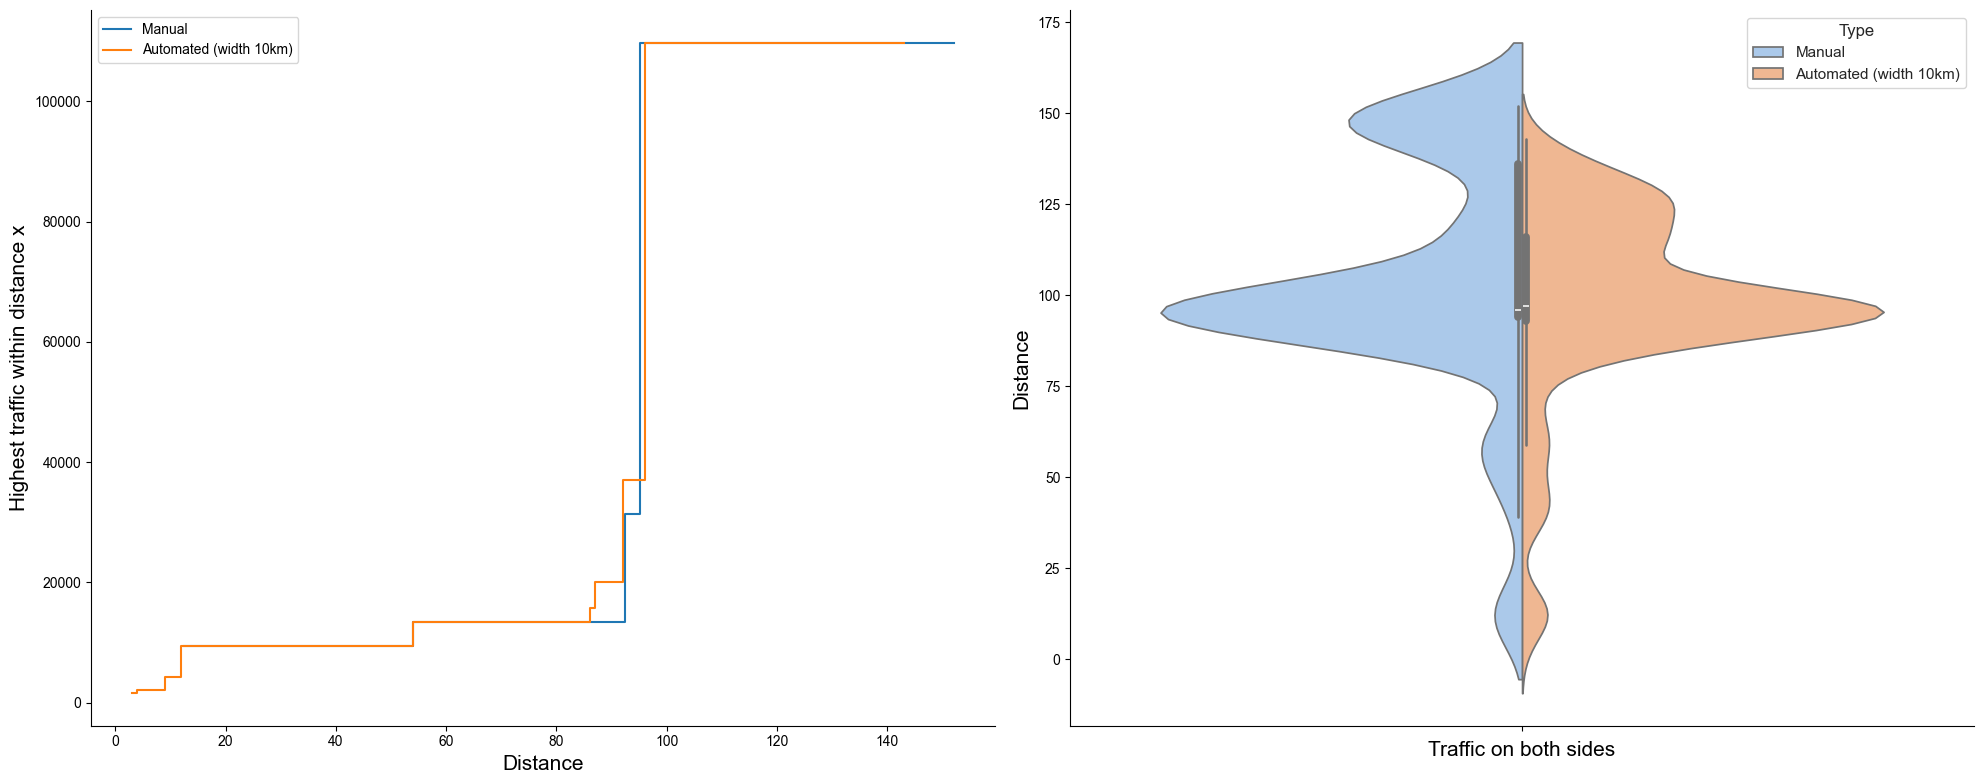

In [4]:
#Create a dataframe which contains all the traffic and the distance in that strip
lt_n, ln_n= get_point_at_distance(s_lat, s_ln, strip_height/2, 0)
lt_s, ln_s= get_point_at_distance(s_lat, s_ln, strip_height/2, 180)
lt_e, ln_e= get_point_at_distance(s_lat, s_ln, strip_length, 90)
d1=d[(d['Latitude']<=lt_n) & (d['Latitude']>=lt_s) & (d['Longitude']<=ln_e) & (d['Longitude']>=s_ln) & (d['All_motor_vehicles']>traffic_bound)]
d1=d1.reset_index()

#Adding the distance to that dataframe
dist=[]
for i in range(len(d1)):
    dist.append(distance(s_lat, d1['Latitude'][i], s_ln, d1['Longitude'][i]))
d1['Distance']=dist

#Data may contain two points which are same distance apart with different traffic. So we take the point with maximum traffic count
for k in range(len(d1)):
    d1['Distance'][k]=int(d1['Distance'][k])

d1=d1.groupby('Distance').max()
d1=d1.reset_index()


#Figure plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

x1=np.array(list(s['Distance']))
y1=np.array(list(s['Cars']))
x2=np.array(list(d1['Distance']))
y2=np.array(list(d1['All_motor_vehicles']))
tmp=[]
y10=[]
for i in range(len(x1)):
    tmp.append(y1[i])
    y10.append(max(tmp))
    
y11=np.array(y10)

tmp1=[]
y20=[]
for i in range(len(x2)):
    tmp1.append(y2[i])
    y20.append(max(tmp1))
    
y21=np.array(y20)

#(x1,y1) is in blue
axes[0].step(x1, y11, label='Manual')
axes[0].step(x2, y21, label=F'Automated (width {strip_height}km)')
axes[0].legend()
axes[0].set_xlabel('Distance', fontsize= 15)
axes[0].set_ylabel('Highest traffic within distance x', fontsize= 15)

#Violin plot by adding distance as many as traffic in the multiplicities 1000
dt=[]
typ=[]
axx=[]
for i in range(len(d1)):
    step=int(d1['All_motor_vehicles'][i]/500)
    for j in range(step):
        dt.append(int(d1['Distance'][i]))
        typ.append(F'Automated (width {strip_height}km)')
        axx.append('')
zp=list(zip(dt,typ,axx))
auto=pd.DataFrame(zp,columns=['Distance','Type','Axes'])

dt1=[]
typ1=[]
axx1=[]
for i in range(len(s)):
    step=int(s['Cars'][i]/500)
    for j in range(step):
        dt1.append(int(s['Distance'][i]))
        typ1.append('Manual')
        axx1.append('')
zp1=list(zip(dt1,typ1,axx1))
manual=pd.DataFrame(zp1,columns=['Distance','Type','Axes'])

jn=pd.concat([manual, auto])


sns.set_theme(style="whitegrid")
sns.violinplot(axes=axes[1],
               data=jn,
               x='Axes',
               y='Distance',
               hue='Type',
               palette='pastel',
               density_norm= 'count',
               split=True)
axes[1].set_ylabel('Distance', fontsize=15)
axes[1].set_xlabel('Traffic on both sides', fontsize=15)
sns.despine()
plt.tight_layout()
plt.show()
fig.savefig(F'{path_to_save}'+F'plot_width_{strip_height}')